In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import visual_behavior.visualization.utils as ut
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.ophys.summary_figures as sf 
import visual_behavior.ophys.response_analysis.utilities as utilities
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

### get multi session dataframe for omission responses (over +/-5 second window round omission)

In [6]:
experiments_table = loading.get_filtered_ophys_experiment_table() 

In [28]:
cache_dir = loading.get_analysis_cache_dir()

df_name = 'omission_response_df' 
conditions = ['cell_specimen_id', 'running', 'engagement_state']
project_codes = ['VisualBehaviorMultiscope']
experiments = experiments_table[experiments_table.project_code.isin(project_codes)]

multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments)
multi_session_df = loading.remove_outlier_traces_from_multi_session_df(multi_session_df)
multi_session_df = loading.remove_problematic_data_from_multi_session_df(multi_session_df)


In [29]:
multi_session_df.head()

,cell_specimen_id,running,engagement_state,mean_response,sem_response,mean_trace,sem_trace,mean_responses,mean_baseline,sem_baseline,...,cre_line,location,location_layer,layer,ophys_session_id,project_code,specimen_id,depth,exposure_number,container_id
0,1018066507,False,engaged,0.016390,0.007537,"[-0.002217556100145398, -0.0036263654861757116...","[0.01218461716928435, 0.014033782829989178, 0....","[-0.014409843399305178, -0.011587322708399591,...",0.007988,0.004772,...,Slc17a7-IRES2-Cre,Excitatory superficial,Slc17a7_VISp_L3,L3,985609503,VisualBehaviorMultiscope,920877188,superficial,0,1018028046
1,1018066507,True,disengaged,-0.001363,0.003050,"[0.003706237509638441, -0.0008813562998791111,...","[0.008431210838153697, 0.0073158210264377, 0.0...","[-0.0130039913766363, -0.009624402806980105, -...",0.001447,0.002771,...,Slc17a7-IRES2-Cre,Excitatory superficial,Slc17a7_VISp_L3,L3,985609503,VisualBehaviorMultiscope,920877188,superficial,0,1018028046
2,1018066507,True,engaged,-0.002135,0.001985,"[0.01094933519161757, 0.00526564687595182, 0.0...","[0.005058709746348743, 0.004900056861915289, 0...","[0.012077502045235979, -0.010154861766406112, ...",0.001017,0.001821,...,Slc17a7-IRES2-Cre,Excitatory superficial,Slc17a7_VISp_L3,L3,985609503,VisualBehaviorMultiscope,920877188,superficial,0,1018028046
3,1018066514,False,engaged,-0.004102,0.004703,"[0.006139713972124044, 0.0051114660194752975, ...","[0.012664311290178485, 0.011878757613379743, 0...","[-0.015508915551001994, -0.01640884079440091, ...",0.001523,0.005311,...,Slc17a7-IRES2-Cre,Excitatory superficial,Slc17a7_VISp_L3,L3,985609503,VisualBehaviorMultiscope,920877188,superficial,0,1018028046
4,1018066514,True,disengaged,0.003457,0.003432,"[0.02693480449126048, -0.009874275563784791, 0...","[0.010888253111622392, 0.011110420099503231, 0...","[0.00928687617082118, 0.013785784911042554, -0...",0.000370,0.004682,...,Slc17a7-IRES2-Cre,Excitatory superficial,Slc17a7_VISp_L3,L3,985609503,VisualBehaviorMultiscope,920877188,superficial,0,1018028046


### get data for omissions during engaged + running condition

In [30]:
df = multi_session_df.copy()
df = df[(df.engagement_state=='engaged')&(df.running==True)]

In [31]:
df.mean_trace.values[0].shape

(107,)

### get all sessions matrix

In [32]:
cre_lines = df.cre_line.unique()

In [33]:
all_sess_ns_fof_all_cre = {}
for cre_line in cre_lines:
    all_sess_ns_fof_all_cre[cre_line] = np.vstack(df[df.cre_line==cre_line].mean_trace.values)
    print(cre_line, len(all_sess_ns_fof_all_cre[cre_line]))

Slc17a7-IRES2-Cre 13125
Vip-IRES-Cre 2667
Sst-IRES-Cre 1006


In [34]:
all_sess_ns_fof_all_cre[cre_line].shape

(1006, 107)

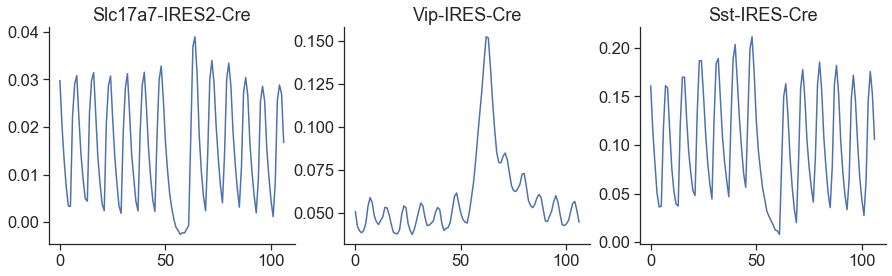

In [35]:
# average trace for each cre line
fig, ax = plt.subplots(1,3, figsize=(15,4))
for i,cre_line in enumerate(cre_lines): 
    ax[i].plot(np.nanmean(all_sess_ns_fof_all_cre[cre_line], axis=0))
    ax[i].set_title(cre_line)

### run PCA 

In [36]:
import visual_behavior.clustering.multiscope_fn.def_funs as funs

Running PCA on Slc17a7-IRES2-Cre, matrix size: (13125, 107)
(13125, 33)
Running PCA on Vip-IRES-Cre, matrix size: (2667, 107)
(2667, 44)
Running PCA on Sst-IRES-Cre, matrix size: (1006, 107)
(1006, 24)


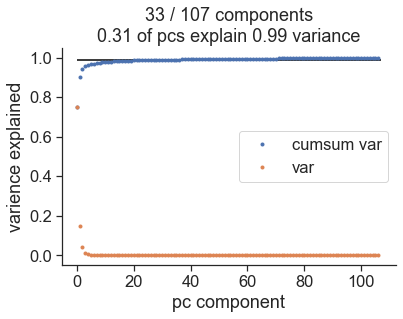

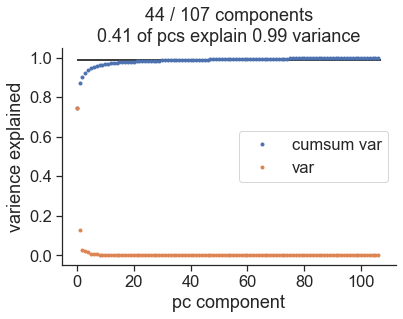

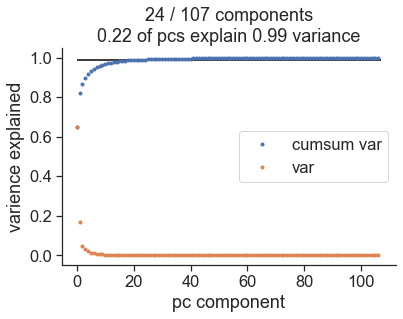

In [37]:
"""
Vars needed here are set in umap_set_vars.py

Here we run umap and pca on the data matrix created in umap_set_vars.py.

After this script run umap_plots.py to make plots.

Created on Mon Jun 29 11:31:25 2020
@author: farzaneh

"""


################################################################################################    
################################################################################################        
#%% Run PCA on all_sess_ns_fof_this_cre
################################################################################################    
################################################################################################    

from sklearn.decomposition import PCA
varexpmax = .99 # 1 # .9

pc_all_cre = {}
pca_variance_all_cre = {}

for cre_line in cre_lines: # icre=0
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running PCA on {cre_line}, matrix size: {np.shape(all_sess_ns_fof_thisCre)}')

    x_train_pc, pca = funs.doPCA(all_sess_ns_fof_thisCre, varexpmax=varexpmax, doplot=1)
    pca_variance = pca.explained_variance_ratio_
#     x_train_pc.shape

    pc_all_cre[cre_line] = x_train_pc
    pca_variance_all_cre[cre_line] = pca_variance
    
    


### run UMAP

In [38]:
################################################################################################    
################################################################################################    
#%% Run umap on all_sess_ns_fof_thisCre
################################################################################################
################################################################################################

import umap    
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

ncomp = 2 # 3 # number of umap components

embedding_all_cre = {}

for cre_line in cre_lines: # icre = 2    
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running UMAP on {cre_line}')

    sp = 2
    neigh = 7
    embedding = umap.UMAP(spread= sp, n_neighbors = neigh, n_components = ncomp).fit_transform(all_sess_ns_fof_thisCre)
    print(f'embedding size: {embedding.shape}')
    embedding_all_cre[cre_line] = embedding
    
# embedding_all_cre_3d = copy.deepcopy(embedding_all_cre)

    
    
###########################################################################
#%% After this script, run umap_plot.py to make plots for umap/pca analysis.    
###########################################################################

Running UMAP on Slc17a7-IRES2-Cre
embedding size: (13125, 2)
Running UMAP on Vip-IRES-Cre
embedding size: (2667, 2)
Running UMAP on Sst-IRES-Cre
embedding size: (1006, 2)


### get some things to label with

In [39]:
df['session_number'] = [int(session_number) for session_number in df.session_number.values]

In [40]:
mean_omission_response = {}
depth = {}
imaging_depth = {}
targeted_structure = {}
session_number = {}
for cre_line in cre_lines:
    mean_omission_response[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].mean_response.values))
    depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].depth.values))
    imaging_depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].imaging_depth.values))
    session_number[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].session_number.values))
    targeted_structure[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].targeted_structure.values))


### plots 

#### colored by mean omission response

In [41]:
low_dim_all_cre = embedding_all_cre

c_value = mean_omission_response.copy()
vmin = np.percentile(df.mean_response.values, 5)
vmax = np.percentile(df.mean_response.values, 95)

Text(0, 0.5, 'mean omission response')

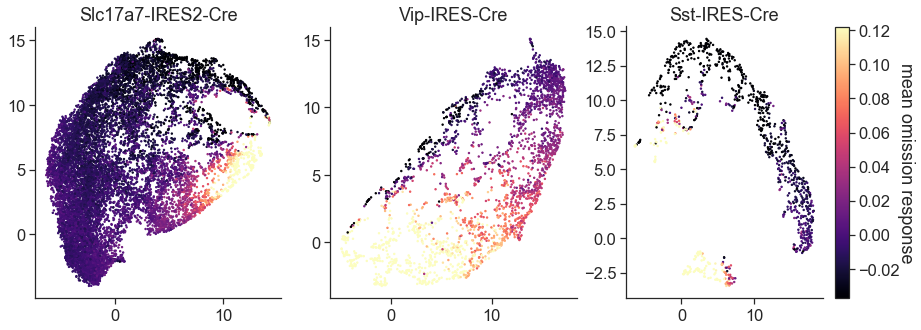

In [42]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('mean omission response', rotation=270)

#### colored by imaging depth

In [44]:
low_dim_all_cre = embedding_all_cre

c_value = imaging_depth.copy()
vmin = np.percentile(df.imaging_depth.values, 5)
vmax = np.percentile(df.imaging_depth.values, 95)

Text(0, 0.5, 'imaging_depth')

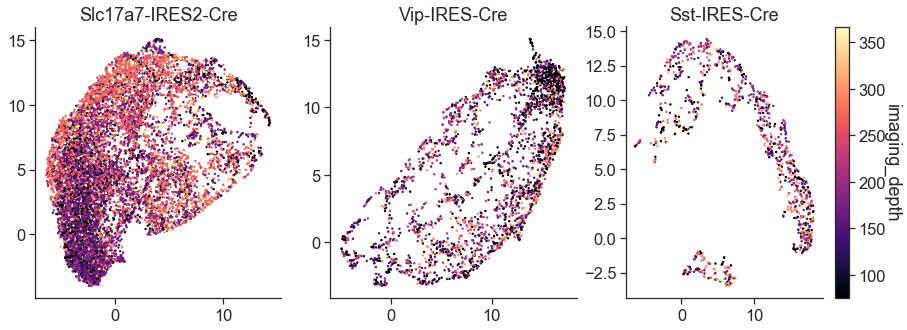

In [45]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('imaging_depth', rotation=270)

#### colored by session_number

In [46]:
low_dim_all_cre = embedding_all_cre

c_value = session_number.copy()
vmin = 1
vmax = 6

Text(0, 0.5, 'session_number')

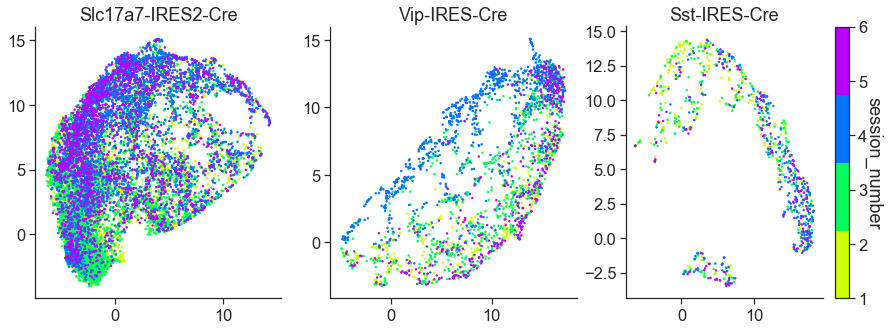

In [47]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('hsv', 4).as_hex())

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('session_number', rotation=270)